In [267]:
import numpy as np
import matplotlib.pyplot as plt

In [268]:
size = 500
times = np.linspace(1, 5, size)

samples = 10

first = np.log(times) + np.sin(times)
second = np.sqrt(times) + np.sin(times * 1.2)

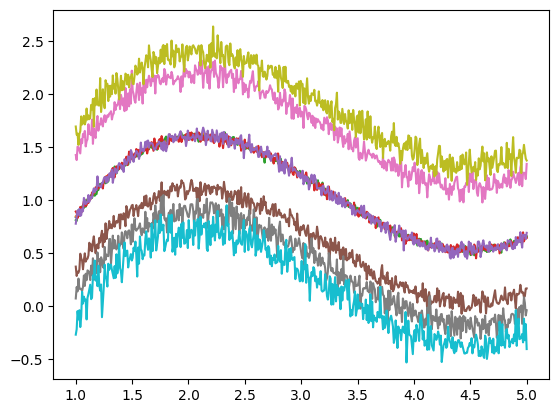

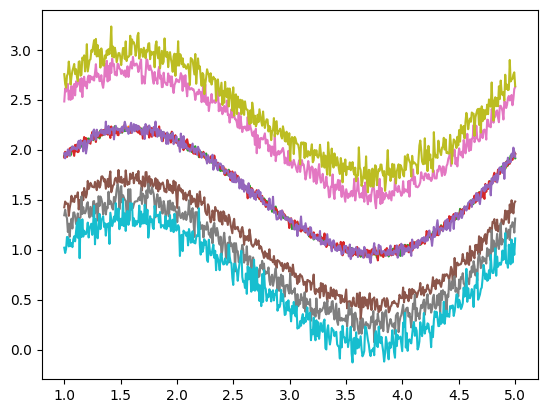

In [269]:
first_classes = []
second_classes = []

for i in range(samples):
    first_classes += [first + np.random.normal(size=size, scale=0.01 * i)]
    second_classes += [second + np.random.normal(size=size, scale=0.01 * i)]

    if i > 4:
        first_classes[i] += ((-1) ** i) * 0.1 * i
        second_classes[i] += ((-1) ** i) * 0.1 * i
for i in range(samples):
    plt.plot(times, first_classes[i])
plt.show()

for i in range(samples):
    plt.plot(times, second_classes[i])
plt.show()

In [270]:
def EuclideanDistance(x, y):
    if len(x[0]) == len(y[0]):
        return np.sqrt(np.sum((np.array(x) - np.array(y)) ** 2))
    
    max_dist = 0
    if len(y[0]) < len(x[0]):
        x, y = y, x
    for i in range(len(y) - len(x)):
        dist = EuclideanDistance(x, y[i:i + len(x)])
        max_dist = max(dist, max_dist)
    return max_dist

def GenerateShapeletCandidates(TS, min, max):
    result = []
    for l in range(min, max + 1):
        for i in range(0, len(TS) - l, l):
            result += [[TS[i:i + l]]]
    return result

def FilterShapelets(x, min = 0.05):
    result = []
    for xi in x:
        if xi[1] <= min:
            result += [xi]
    return result

def SortShapelets(shapelets):
    return sorted(shapelets, key=lambda x: x[1])

def InsertShapelet(rShapelets, shapelet):
    result = []
    i = 0
    for i in range(len(rShapelets)):
        if rShapelets[i][1] <= shapelet[1]:
            result += [rShapelets[i]]
        if rShapelets[i][1] > shapelet[1]:
            if i == 0 or rShapelets[i - 1][1] < shapelet[1]:
                result += [shapelet]
            else:
                result += [rShapelets[i - 1]]
    return result

def MergeShapelets(p, rShapelets, shapelets):
    if len(rShapelets) == 0:
        return shapelets[0:p]
    result = rShapelets
    for shapelet in shapelets:
        if shapelet[1] < rShapelets[len(rShapelets) - 1][1]:
            rShapelets = InsertShapelet(result, shapelet)
    return result


def DiscoverShapelets(TS, min_size = 3, max_size = -1, r = -1, quality = 0.05):
    if max_size == -1:
        max_size = len(TS)
    if r == -1:
        r = 10 * len(TS)
    if min_size > max_size:
        min_size, max_size = max_size, min_size
    rShapelets = []    
    for TSi in TS:
        shapelets = []
        Wi = GenerateShapeletCandidates(TSi, min_size, max_size)
        W = []
        for TSj in TS:
            W += [GenerateShapeletCandidates(TSj, min_size, max_size)]        
        for S in Wi:
            min_dist = 100000
            for Wj in W:
                for Si in Wj:
                    Ds = EuclideanDistance(S, Si)
                    if Ds > 0:
                        min_dist = min(min_dist, Ds)
            shapelets += [(S[0], min_dist)]
        shapelets = FilterShapelets(shapelets, quality)
        shapelets = SortShapelets(shapelets)
        rShapelets = MergeShapelets(r, rShapelets, shapelets)
    return rShapelets

In [271]:
# Ищём шейплеты одинаковых размеров, чтобы можно было предсказывать с помощью классификатора.
shapelet_size = 3
shapelets_from_first_class = DiscoverShapelets(first_classes, min_size = shapelet_size, max_size = shapelet_size, r = 100)
shapelets_from_second_class = DiscoverShapelets(second_classes, min_size = shapelet_size, max_size = shapelet_size, r = 100)

print('First class:\n----------------------------------------\n\n', shapelets_from_first_class[:10], '\n\nSecond class:\n----------------------------------------\n\n', shapelets_from_second_class[:10])

First class:
----------------------------------------

 [(array([0.52675947, 0.52660612, 0.52651195]), 0.0003099979501557899), (array([0.52647709, 0.52650168, 0.52658582]), 0.0003099979501557899), (array([1.60538212, 1.60548747, 1.60552122]), 0.00035811757921617787), (array([1.60548376, 1.60537544, 1.60519662]), 0.00035811757921617787), (array([0.52672965, 0.52693328, 0.52719682]), 0.0007595879256612444), (array([0.52757318, 0.52724314, 0.52697185]), 0.0009263754344413781), (array([1.60463299, 1.60495524, 1.60520483]), 0.0009489182392150291), (array([1.60494769, 1.604629  , 1.60424094]), 0.0010651555693518013), (array([0.52891434, 0.52840894, 0.52796183]), 0.0014897912660190857), (array([0.52752039, 0.52790407, 0.52834799]), 0.0015275366796754896)] 

Second class:
----------------------------------------

 [(array([2.20451923, 2.20462061, 2.20462644]), 0.0006139206961011446), (array([2.20453708, 2.20435289, 2.20407425]), 0.0006139206961011446), (array([0.95951665, 0.95924565, 0.9590622

In [272]:
import random

x = []
Y = []
data = shapelets_from_first_class + shapelets_from_second_class

for i in range(len(data)):
    res = list(data[i][0])
    # Объединяем шейплет и его quality в один массив, чтобы классификатор корректно работал.
    res += [data[i][1]]    
    x.append(res)
    if i < len(shapelets_from_first_class):
        Y.append(1)
    else:
        Y.append(2)

X_train = []
X_test = []
y_train = []
y_test = []
print(data[0], x[0])
indexes = np.arange(len(Y))
random.shuffle(indexes)
for i in range(int(len(Y) * 2 / 3)):
    X_train.append(x[indexes[i] - 1])
    y_train.append(Y[indexes[i] - 1])

for i in range(int(len(Y) * 2 / 3), len(Y)):
    X_test.append(x[indexes[i] - 1])
    y_test.append(Y[indexes[i] - 1])

print(X_train)
print(y_train)

print(X_test)
print(y_test)

(array([0.52675947, 0.52660612, 0.52651195]), 0.0003099979501557899) [0.5267594653469282, 0.526606119409244, 0.5265119514500276, 0.0003099979501557899]
[[1.0692806197250349, 1.0652165003928837, 1.06122030691923, 0.008084093821093636], [1.5383230514785016, 1.5311983002363474, 1.5240807531976759, 0.008685151349084949], [0.9592088498308221, 0.9594665320197828, 0.9598129876168207, 0.0008409205485087088], [0.5288522195039604, 0.5294168636537548, 0.5300420069730688, 0.0021202290928442557], [0.782327943779049, 0.7776865457686057, 0.7730745793933698, 0.005890476830634731], [1.598405348423011, 1.5993971967427516, 1.6003132812357208, 0.0029754197325300435], [1.4093769912719298, 1.417903555143035, 1.4264950183593117, 0.007141767482363231], [0.6270777230037234, 0.6238981589287297, 0.620763820627927, 0.002520622996889124], [1.1052079594711568, 1.1148397470339215, 1.124367041810689, 0.004107215386755042], [0.8779831645568491, 0.8899206191568138, 0.9017425906650343, 0.008696839627907377], [1.43515076

In [273]:
from pyts.classification import TimeSeriesForest
 
clf = TimeSeriesForest()
clf.fit(X_train, y_train)

print("--- Классификатор TimeSeriesForest ---\n")
print(f"Accuracy = {clf.score(X_test, y_test)}")
for i in range(len(X_test)):
    print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(np.array(X_test[i]).reshape(1, -1))[0]}")
    print(f"Истинный класс для предсказаний {y_test[i]}\n")

--- Классификатор TimeSeriesForest ---

Accuracy = 0.8955223880597015
Вектор вероятности принадлежности к классам [0.776 0.224]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [1. 0.]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [0.876 0.124]
Истинный класс для предсказаний 1

Вектор вероятности принадлежности к классам [0. 1.]
Истинный класс для предсказаний 2

Вектор вероятности принадлежности к классам [0. 

Классификатор намного лучше предсказывает шейплеты большей длины, для длины 6 - это около 0.90 accuracy и даже больше, а вот для длины 8 - это уже 0.8 accuracy. Дело в том, что при длинных шейплетах их итоговое количество маленькое, из-за чего классификатор хуже предсказывает.